In [1]:
import re
from Bio import SeqIO
import pandas as pd
from pyteomics import mass,parser
import numpy as np
import matplotlib.pyplot as plt

In [4]:
proteases=dict()
proteases['Trypsin'] = re.compile(r'(K|R)(?!P)')
proteases['Chymo'] = re.compile(r'(F|Y|W|L)')
#proteases['GluC'] = re.compile(r'(D|E)(?!P)')

mis_cleave =dict()
mis_cleave['Trypsin'] = 1
mis_cleave['Chymo'] = 2




Y_CPattern = re.compile(r'Y\wC')
WG_GPattern = re.compile(r'(WG\wG)|(W\wQG)|(\wGQG)|(\w\wQG)|(WG\w\w)|(W\w\wG)|(W\wQ\w)')

In [2]:
def find_cdr3(sequence):
    left_area = sequence[90:105]
    la_i = -1
    left_cdr = -1
    Y_C = Y_CPattern.search(left_area)
    if Y_C != None:
        # if we found 'YXR', find its index
        la_i = Y_C.start(0) + 2
    else:
        return None

    if la_i >= 0:
        left_cdr = la_i + 90 + 3
        
    n1 = left_cdr + 5
    subtract_amount = 1
    right_area = sequence[n1:]
    ra_i = -1
    right_cdr = -1
    WG_G = WG_GPattern.search(right_area)
    if WG_G != None:
        ra_i = WG_G.start(0)
    else:
        return None
        
    if ra_i >= 0:
        right_cdr = ra_i + n1 - subtract_amount +1  # CDR3 ends at 'W' - 1 (or 'Q' - 3) (add n-14 to put it back in the full sequence)
    return [left_cdr, right_cdr]

def find_coverage(cdr3_region,peptide_region):
    _start = max([cdr3_region[0], peptide_region[0]])
    _end = min([cdr3_region[1], peptide_region[1]])

    overlap = _end - _start
    if overlap > 0:
        return [True, overlap / (cdr3_region[1] - cdr3_region[0])]
    else:
        return [False, None]
    
    
def get_cleaved_pos(sequence:str,cleaved_rule):
    positions =  [pos.span()[0]+1 for pos in cleaved_rule.finditer(sequence)]
    positions.insert(0,0)
    positions.append(len(sequence))
    return positions
def get_cdr3_peptides_coverages(sequence,cdr3_region,cleaved_rule,miscleavage_allowed):
    pos = get_cleaved_pos(sequence,cleaved_rule)
    result = []
    for miscleavage in range(miscleavage_allowed+1):
        for i in range(len(pos)-miscleavage-1):
            overlap = find_coverage(cdr3_region,[pos[i],pos[i+1+miscleavage]])
            if overlap[0]:
                result.append([overlap[1],mass.fast_mass(sequence[pos[i]:pos[i+1+miscleavage]]),pos[i+1+miscleavage]-pos[i],sequence[pos[i]:pos[i+1+miscleavage]]])
    return result
def miscleavage_cumsum_norm(num):
    Sum = 0
    for i in range(1,num+2):
        Sum += i
    return Sum


In [5]:
data=dict()
for k in proteases.keys():
    data[k] = []
NumSeq = 0

for record in SeqIO.parse("D:\\ZheS\\database\\GST_BM\\7168_Mito_GST_Fam60a_EGFR_morethan2_longhinge.fasta",format="fasta"):
    _id = str(record.id)
    _copy = int(float(_id.split('-')[-2]))
    if _copy <10:
        continue
    sequence = str(record.seq)
    if len(sequence)<110:
        continue
        
    cdr3_region = find_cdr3(sequence)
    if cdr3_region !=None:
        for k in proteases.keys():
            data[k] += get_cdr3_peptides_coverages(sequence,cdr3_region,proteases[k],mis_cleave[k])
        NumSeq+=1



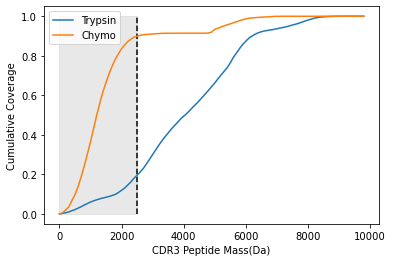

In [9]:
plt.figure()

for k in proteases.keys():
    df = pd.DataFrame(data[k],columns=['coverage','mass','Len','Sequence'])
    h,x  = np.histogram(df['mass'], bins=np.arange(0,10000,100),weights=df['coverage']/(NumSeq*miscleavage_cumsum_norm(mis_cleave[k])))
    h = np.cumsum(h)
    plt.plot(x[:-1],h,label=k)
plt.vlines(2500,0,np.max(h),linestyles='dashed')
plt.fill_between([0,2500],0,[1,1],alpha=0.5,color='lightgrey')
plt.xlabel("CDR3 Peptide Mass(Da)")
plt.ylabel("Cumulative Coverage")
plt.legend()

#plt.savefig("3_proteases_performance.svg",format='svg')

Text(0, 0.5, 'fraction')

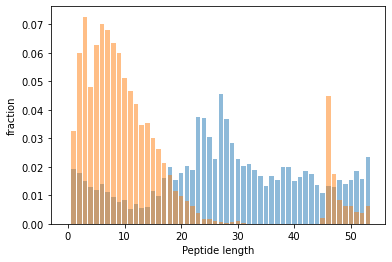

In [8]:
trypsin = pd.DataFrame(data['Trypsin'],columns=['coverage','mass','Len','Seq'])
chymo = pd.DataFrame(data['Chymo'],columns=['coverage','mass','Len','Seq'])
h,x  = np.histogram(trypsin['Len'], bins=np.arange(0,55,1),weights=np.ones(trypsin.shape[0])/trypsin.shape[0])
plt.bar(x[:-1],h,alpha=0.5)
h,x  = np.histogram(chymo['Len'], bins=np.arange(0,55,1),weights=np.ones(chymo.shape[0])/chymo.shape[0])
plt.bar(x[:-1],h,alpha=0.5)
plt.xlabel("Peptide length")
plt.ylabel("fraction")